In [2]:
from collections import Counter
from itertools import combinations
import statistics
import polars as pl
import numpy as np
import pickle
import lib.generator as gen
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import LocalOutlierFactor
from kelso_model import *
import sys
import os
from scipy.spatial.distance import jensenshannon

path_to_add = "/home/gbenanti/Tesi_Benanti/SETOR"
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

sys.path.append(os.path.abspath("../.."))

import torch

import random
import pandas as pd
from datetime import datetime
import argparse
import os

ontology_path = '../data/processed/ontology.parquet'
diagnoses_path = '../data/processed/diagnoses.parquet'
generation_path = '../data/processed/generation.parquet'
ccs_path = '../data/processed/ccs.parquet'
icd_path = '../data/processed/icd.parquet'

###### IMPOSTARE PRIMA DELL'ESECUZIONE ######


###### IMPOSTARE PRIMA DELL'ESECUZIONE ######


# Path to the filler model
filler_path = 'results/filler-mpgzq-2025-02-19_19:17:59'


k_reals = 10
synthetic_neighborhood_size = 200
batch_size = 64
keep_prob = 0.95 # for ontological perturbation
llm_musk_prob = 0.05 # for generative perturbation
topk_predictions = 10
uniform_perturbation = False
tree_train_fraction = 0.75
synthetic_multiply_factor = 4
generative_multiply_factor = 4

APPLE_SILICON = False
# modificare il device in base alla disponibiltà di una GPU
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#############################################

random.seed(42)
np.random.seed(seed=42)
torch.manual_seed(seed=42)

def main(interval):
    """
    Main function for processing medical data, generating synthetic data, and explaining predictions using decision trees.
    Args:
        interval (int): interval of the index of the reference patients in the test dataset.
        ontological_perturbation (bool): Whether to apply ontological perturbation to the neighborhood data.
        generative_perturbation (bool): Whether to apply generative perturbation to the neighborhood data.
    Returns:
        tuple: A tuple containing:
            - fidelity_synth (float): Fidelity of the decision tree to the black-box model on the synthetic neighborhood.
            - hit_synth (float): Hit rate of the decision tree on the synthetic neighborhood.
    Raises:
        ValueError: If unexpected conditions occur during processing, such as missing or inconsistent data.
    Notes:
        - This function loads and processes data from multiple sources, including SETOR and DoctorXAI datasets.
        - It computes distances between patients, generates synthetic neighbors, and explains predictions using a decision tree.
        - The function also prints detailed information about the reference patient, predicted labels, decision rules, and relevant codes.
    """
    
    # Load DoctorXAI data
    ontology = pl.read_parquet(ontology_path)
    diagnoses = pl.read_parquet(diagnoses_path)
    ccs_data = pl.read_parquet(ccs_path)
    icd9_data = pl.read_parquet(icd_path)
    icd9_data = icd9_data.join(ontology.select(['icd9_id', 'icd_code', 'label']), on=['icd9_id', 'icd_code'], how='left').fill_null('No description')

    
    # Load base data and model
    diagnoses_train = diagnoses.filter(pl.col('role') == 'train')
    diagnoses_eval  = diagnoses.filter(pl.col('role') == 'eval')
    diagnoses_test  = diagnoses.filter(pl.col('role') == 'test')

    unique_codes = diagnoses['icd9_id'].explode().unique().to_numpy()
    max_ccs_id = ccs_data['ccs_id'].max() + 1
    max_icd_id = unique_codes.max() + 1

    ontology_array = ontology[['icd9_id', 'parent_id']].to_numpy()
    # viene usato da compute_patient_distances
    gen.create_c2c_table(ontology_array, unique_codes)

    # Extract the numpy data

    icd_codes_all = list(diagnoses['icd9_id'].to_numpy())
    ccs_codes_all = list(diagnoses['ccs_id'].to_numpy())
    positions_all = list(diagnoses['position'].to_numpy())
    counts_all = list(diagnoses['count'].to_numpy())

    ccs_codes_test = list(diagnoses_test['ccs_id'].to_numpy())
    icd_codes_test = list(diagnoses_test['icd9_id'].to_numpy())
    positions_test = list(diagnoses_test['position'].to_numpy())
    counts_test = list(diagnoses_test['count'].to_numpy())


    filler, hole_prob, hole_token_id = load_kelso_for_generation(filler_path, device)
    hole_prob = llm_musk_prob
    conv_data = pl.read_parquet(generation_path).sort('out_id')
    zero_row  = pl.DataFrame({'icd9_id':0, 'out_id':0, 'ccs_id':0}, schema=conv_data.schema)
    conv_data = pl.concat([zero_row, conv_data])

    out_to_icd = conv_data['icd9_id'].to_numpy()
    out_to_ccs = conv_data['ccs_id' ].to_numpy()

    #print test parameters

    print(f'llm_musk_prob: {llm_musk_prob}')
    print(f'Keep prob: {keep_prob}')
    print(f'k_reals: {k_reals}')
    print(f'Synthetic neighborhood size: {synthetic_neighborhood_size}')
    
    for reference_index in range(interval[0], interval[1]):
        print(f'Processing patient {reference_index}/{interval[1]}...')

        # Find closest neighbours in the real data
        distance_list = gen.compute_patients_distances (
            icd_codes_test[reference_index],
            counts_test[reference_index],
            icd_codes_all,
            counts_all
        )

        # topk include the reference patient
        topk = np.argpartition(distance_list, k_reals+1)[:k_reals+1]

        real_neigh_icd = []
        real_neigh_ccs = []
        real_neigh_counts = []
        real_neigh_positions = []
        ont_synt_neigh_icd = []
        ont_synt_neigh_ccs = []
        ont_synt_neigh_counts = []
        ont_synt_neigh_positions = []
        gen_synt_neigh_icd = []
        gen_synt_neigh_ccs = []
        gen_synt_neigh_counts = []
        gen_synt_neigh_positions = []

        # prendo i 50 sample più simili al paziente di riferimento
        for it in range(k_reals+1):
            real_neigh_icd.append(icd_codes_all[topk[it]])
            real_neigh_ccs.append(ccs_codes_all[topk[it]])
            real_neigh_counts.append(counts_all[topk[it]])
            real_neigh_positions.append(positions_all[topk[it]])

        # augment the neighbours with some synthetic points
        # first, generate the ontological perturbation

        while len(ont_synt_neigh_icd) < synthetic_neighborhood_size:
            displacements, new_counts = gen.ontological_perturbation(real_neigh_icd, real_neigh_counts, synthetic_multiply_factor, keep_prob)

            new_neigh_icd = []
            new_neigh_ccs = []
            new_neigh_positions = []
            
            for it, (icd, ccs, pos) in enumerate(zip(real_neigh_icd, real_neigh_ccs, real_neigh_positions)):
                for jt in range(synthetic_multiply_factor):
                    displ = displacements[synthetic_multiply_factor * it + jt]
                    new_neigh_icd.append(icd[displ])
                    new_neigh_ccs.append(ccs[displ])
                    new_neigh_positions.append(pos[displ])

            ont_synt_neigh_icd += new_neigh_icd
            ont_synt_neigh_ccs += new_neigh_ccs
            ont_synt_neigh_positions += new_neigh_positions
            ont_synt_neigh_counts += new_counts

        new_neigh_icd = []
        new_neigh_ccs = []
        new_neigh_counts = []
        new_neigh_positions = []

        # augment the neighbours with some generative points
        
        while len(new_neigh_icd) < synthetic_neighborhood_size:
            cursor = 0
            while cursor < len(real_neigh_icd):
                new_cursor = min(cursor + batch_size, len(real_neigh_icd))

                for _ in range(generative_multiply_factor):
                    batch = prepare_batch_for_generation (
                        real_neigh_icd[cursor:new_cursor],
                        real_neigh_counts[cursor:new_cursor],
                        real_neigh_positions[cursor:new_cursor],
                        hole_prob,
                        hole_token_id,
                        device
                    )

                    if uniform_perturbation:
                        bsz = batch.codes.shape[0]
                        b_n = batch.codes.shape[1]
                        n_out = filler.head.out_features
                        gen_output = torch.zeros((bsz, b_n, n_out))
                    else:
                        gen_output = filler(**batch.unpack()) # (batch_size, seq_len, out_features)
                    # batch_size = 64, seq_len = 62, out_features (top k codici icd9 più frequenti) = 500
                    old_shape = gen_output.shape
                    gen_output = gen_output.reshape((-1, gen_output.shape[-1]))
                    gen_output = torch.softmax(gen_output, dim=-1)
                    gen_output.shape # 3968x500
                    new_codes = torch.multinomial(gen_output, 1)
                    new_codes = new_codes.reshape(old_shape[:-1])
                    new_codes.shape # 64x62
                    new_codes = new_codes.cpu().numpy()

                    new_icd = list(out_to_icd[new_codes])
                    new_ccs = list(out_to_ccs[new_codes])

                    # aggiungo solo i codici generati, escludendo i codici di padding
                    for i, pos in enumerate(real_neigh_positions[cursor:new_cursor]):
                        new_neigh_icd.append(new_icd[i][:len(pos)])
                        new_neigh_ccs.append(new_ccs[i][:len(pos)])

                    new_neigh_counts += real_neigh_counts[cursor:new_cursor]
                    new_neigh_positions += real_neigh_positions[cursor:new_cursor]

                cursor = new_cursor

        gen_synt_neigh_icd += new_neigh_icd
        gen_synt_neigh_ccs += new_neigh_ccs
        gen_synt_neigh_counts += new_neigh_counts
        gen_synt_neigh_positions += new_neigh_positions

    return ont_synt_neigh_icd, gen_synt_neigh_icd

llm_musk_prob: 0.05
Keep prob: 0.95
k_reals: 10
Synthetic neighborhood size: 200
Processing patient 0/1...


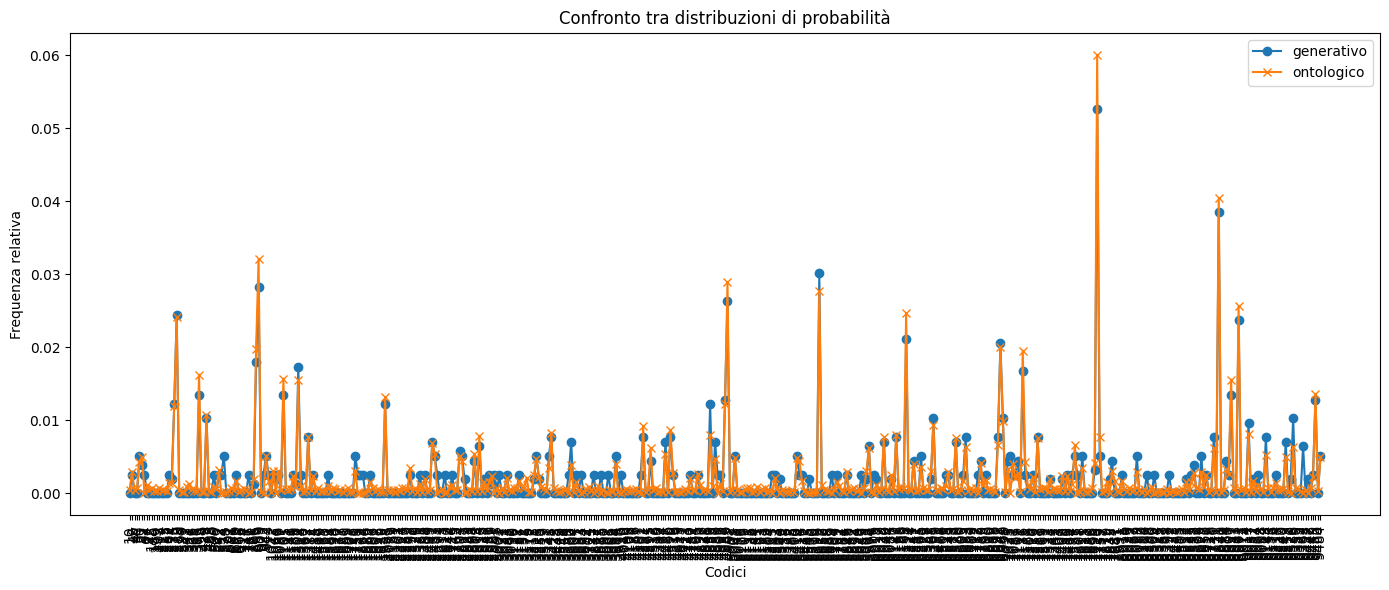

Distanza di Jensen–Shannon: 0.2915


In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from scipy.spatial.distance import jensenshannon

main_interval = (0, 1)
ont_neigh, gen_neigh = main(main_interval)  # Example interval for processing patients

# convert lists of lists to single list
gen_synt_neigh_icd = [item for sublist in ont_neigh for item in sublist]
ont_synt_neigh_icd = [item for sublist in gen_neigh for item in sublist]

list1 = [x for x in gen_synt_neigh_icd if x != 0]
list2 = [x for x in ont_synt_neigh_icd if x != 0]

# Frequenze relative
def rel_freq(data):
    counter = Counter(data)
    total = len(data)
    return {k: v / total for k, v in counter.items()}

dist1 = rel_freq(list1)
dist2 = rel_freq(list2)

# Unione dei codici
all_keys = sorted(set(dist1) | set(dist2))
vec1 = [dist1.get(k, 0) for k in all_keys]
vec2 = [dist2.get(k, 0) for k in all_keys]

# Plot
plt.figure(figsize=(14, 6))
plt.plot([str(k) for k in all_keys], vec1, marker='o', label='generativo')
plt.plot([str(k) for k in all_keys], vec2, marker='x', label='ontologico')
plt.title("Confronto tra distribuzioni di probabilità")
plt.xlabel("Codici")
plt.ylabel("Frequenza relativa")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Jensen–Shannon Distance
js_distance = jensenshannon(vec1, vec2)
print(f"Distanza di Jensen–Shannon: {js_distance:.4f}")

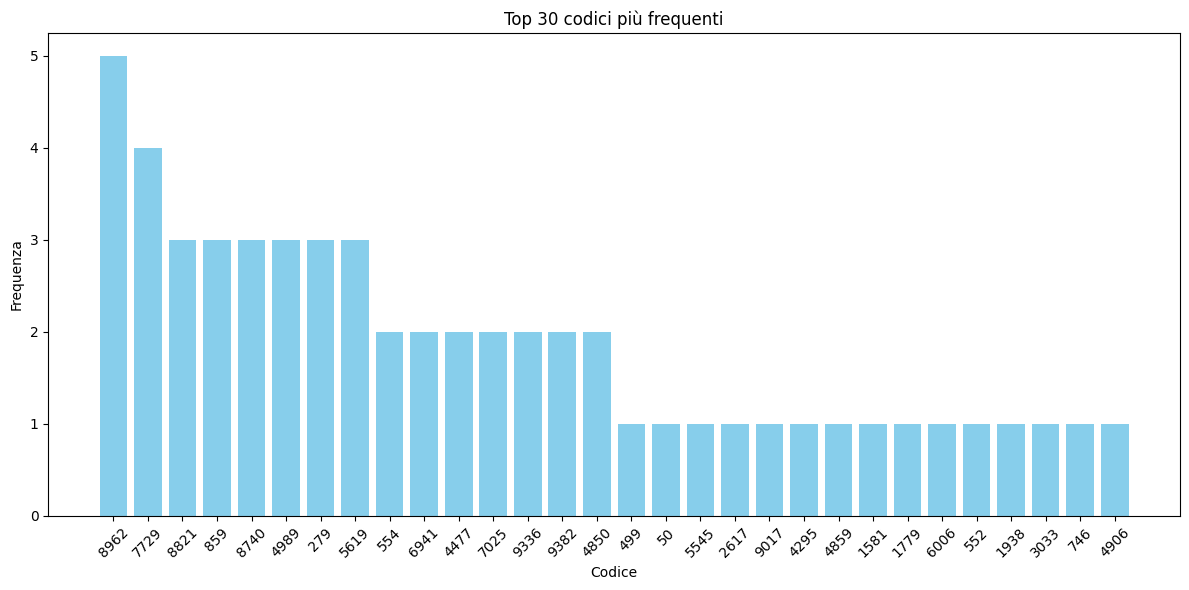

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Lista dei tuoi dati (esempio)
data = [8962, 8821, 554, 499, 6941, 4477, 50, 5545, 2617, 6941, 8962, 554, 7729,
        4477, 9017, 4295, 859, 7025, 4859, 0, 9336, 1581, 8740, 1779, 4989, 6006,
        552, 7729, 1938, 279, 3033, 746, 5619, 4906, 7210, 1759, 8309, 6036,
        7109, 8962, 9382, 7025, 859, 7611, 4989, 9382, 8962, 0, 6960, 8623,
        8740, 8821, 4850, 7729, 1101, 279, 3885, 1751, 5619, 859, 6579, 8740,
        7832, 7729, 4989, 9336, 279, 275, 8962, 3002, 5619, 4850, 0, 1377,
        6756, 8821, 6733]

# Rimuovi i valori 0
filtered = [x for x in data if x != 0]

# Conta le frequenze
counter = Counter(filtered)

# Prendi i top N più frequenti
top_n = 30

most_common = counter.most_common(top_n)

# Estrai chiavi e valori per il grafico
labels = [str(k) for k, _ in most_common]
frequencies = [v for _, v in most_common]

# Crea l'istogramma
plt.figure(figsize=(12, 6))
plt.bar(labels, frequencies, color='skyblue')
plt.title(f"Top {top_n} codici più frequenti")
plt.xlabel("Codice")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()